# Exercises
- The end result of this exercise should be a Jupyter notebook named model.

- Using saas.csv or log data from API usage or store_item_sales


In [2]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")


##  1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.


In [3]:
#acquiring csv
saas_df= pd.read_csv('saas.csv')

In [4]:
saas_df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
#Looking at value counts in amount to decide whether to change to int or not
saas_df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [6]:
#Looking at datatypes
saas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [7]:
# Setting datatime datatype
saas_df.Month_Invoiced= pd.to_datetime(saas_df.Month_Invoiced)

In [8]:
# Set the index to be the datetime variable.
saas_df= saas_df.set_index('Month_Invoiced').sort_index()

In [9]:
#Changing Subscription Type column to integer datatype
saas_df.Subscription_Type= saas_df.Subscription_Type.astype('int')

In [10]:
#Changing amount column to integer datatype
saas_df.Amount= saas_df.Amount.astype('int')

In [11]:
#Verify datatype was changed
saas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Customer_Id        790458 non-null  int64
 1   Invoice_Id         790458 non-null  int64
 2   Subscription_Type  790458 non-null  int64
 3   Amount             790458 non-null  int64
dtypes: int64(4)
memory usage: 30.2 MB


In [12]:
# aggregate or resample daily by summing Amount
df_resampled = saas_df.resample('d')['Amount'].sum()

In [13]:
#Looking at the first 5 values of df_resampled
df_resampled.head()

Month_Invoiced
2014-01-31    35850
2014-02-01        0
2014-02-02        0
2014-02-03        0
2014-02-04        0
Freq: D, Name: Amount, dtype: int64

## Split

In [14]:
# set train size to be 50% of total 
train_size = int(len(saas_df) * 0.5)
train_size

395229

In [15]:
# set validate size to be 30% of total 
validate_size = int(len(saas_df) * 0.3)
validate_size

237137

In [16]:
# set test size to be number of rows remaining. 
test_size = int(len(saas_df) - train_size - validate_size)
test_size

158092

In [17]:
validate_end_index = train_size + validate_size
validate_end_index

632366

In [19]:
# train 
train = saas_df[:train_size]
# validate
validate = saas_df[train_size:validate_end_index]
# test 
test = saas_df[validate_end_index:]

In [22]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(saas_df))

True


In [23]:
print(saas_df.head(1) == train.head(1))

                Customer_Id  Invoice_Id  Subscription_Type  Amount
Month_Invoiced                                                    
2014-01-31             True        True               True    True


In [24]:
pd.concat([train.tail(1), validate.head(1)])

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2015-10-31,1019181,5395228,0,0
2015-10-31,1019182,5395229,0,0


In [26]:
pd.concat([test.tail(1), saas_df.tail(1)])

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2017-12-31,1029399,5790457,0,0
2017-12-31,1029399,5790457,0,0


In [27]:
train.columns

Index(['Customer_Id', 'Invoice_Id', 'Subscription_Type', 'Amount'], dtype='object')

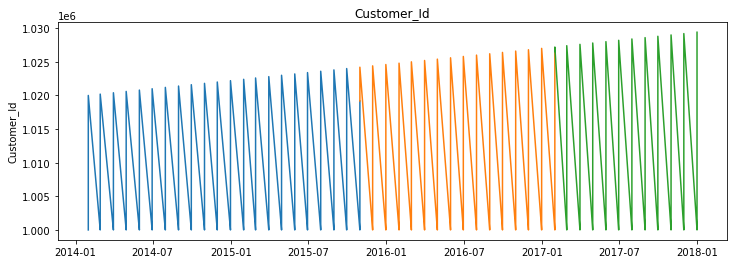

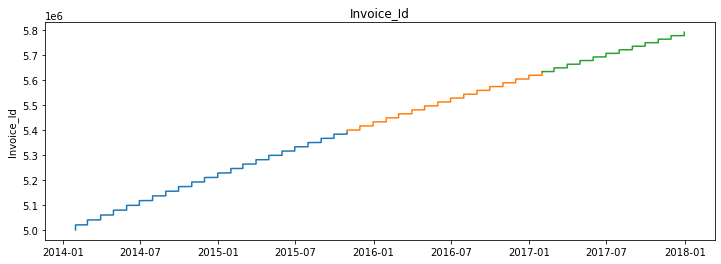

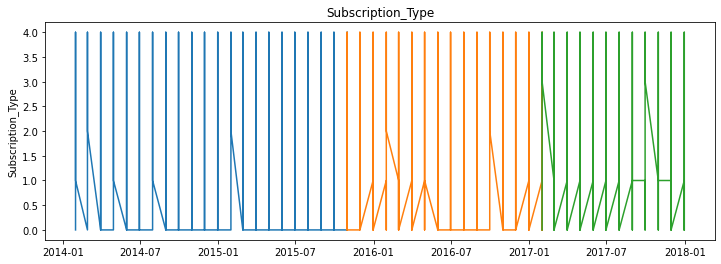

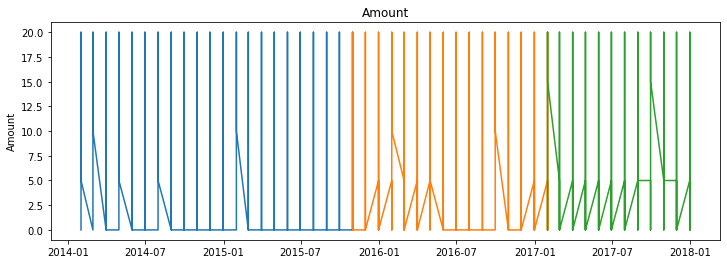

In [28]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [31]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [82]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [83]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [84]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [85]:
eval_df

,model_type,target_var,rmse


## 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

# Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

<b>Make Predictions</b>

In [86]:
# compute simple average
amt = round(train['Amount'].mean(), 2)

amt

2.48

In [87]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amt]},
                          index=validate.index)
    return yhat_df

In [88]:
yhat_df = make_predictions()

In [89]:
yhat_df.head()

,Amount
Month_Invoiced,
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48


In [90]:
yhat_df.describe()

,Amount
count,2.371370e+05
mean,2.480000e+00
std,8.285390e-12
min,2.480000e+00
25%,2.480000e+00
50%,2.480000e+00
75%,2.480000e+00
max,2.480000e+00


In [91]:
yhat_df.columns

Index(['Amount'], dtype='object')

Amount -- RMSE: 5


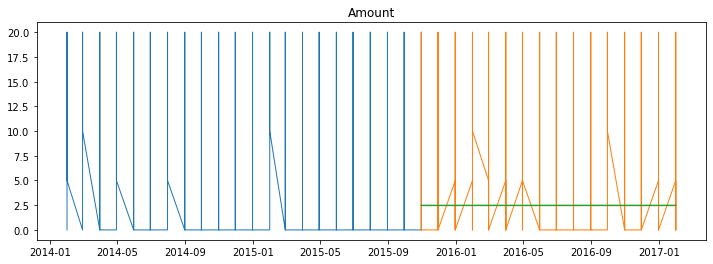

In [93]:
plot_and_eval('Amount')

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [96]:
for col in yhat_df.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Amount,5.0


# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [101]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['Amount'].rolling(30).mean())

Month_Invoiced
2014-01-31         NaN
2014-01-31         NaN
2014-01-31         NaN
2014-01-31         NaN
2014-01-31         NaN
                ...   
2015-10-31    3.166667
2015-10-31    3.166667
2015-10-31    3.166667
2015-10-31    3.166667
2015-10-31    2.833333
Name: Amount, Length: 395229, dtype: float64


**Make Predictions**

In [102]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
amt2= round(train['Amount'].rolling(period).mean()[-1], 2)
print(amt2)

2.83


In [103]:
yhat_df = make_predictions()
yhat_df.head()

,Amount
Month_Invoiced,
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48
2015-10-31,2.48


Amount -- RMSE: 5


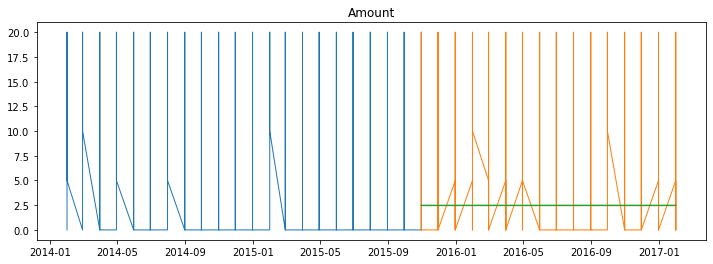

In [104]:
plot_and_eval('Amount')

# Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [105]:
for col in yhat_df.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Amount,5.0
1,30d_moving_avg,Amount,5.0


# Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target.

Amount 



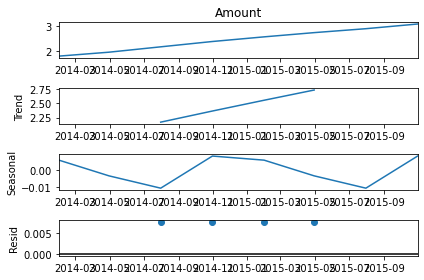

In [117]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
plt.show()

In [121]:
# col = 'Amount'
# # create the Holt object 
# model = Holt(train[col], exponential=False, damped=True)
# # fit the model 
# model = model.fit(optimized=True)
# # make predictions for each date in validate 
# yhat_items = model.predict(start = validate.index[0],
#                            end = validate.index[-1])
# # add predictions to yhat_df
# yhat_df[col] = round(yhat_items, 2)